In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [2]:
import glob
import pickle
import matplotlib.pyplot as plt
import numpy as np
import colorcet as cc
from importlib import reload
from scipy.optimize import curve_fit


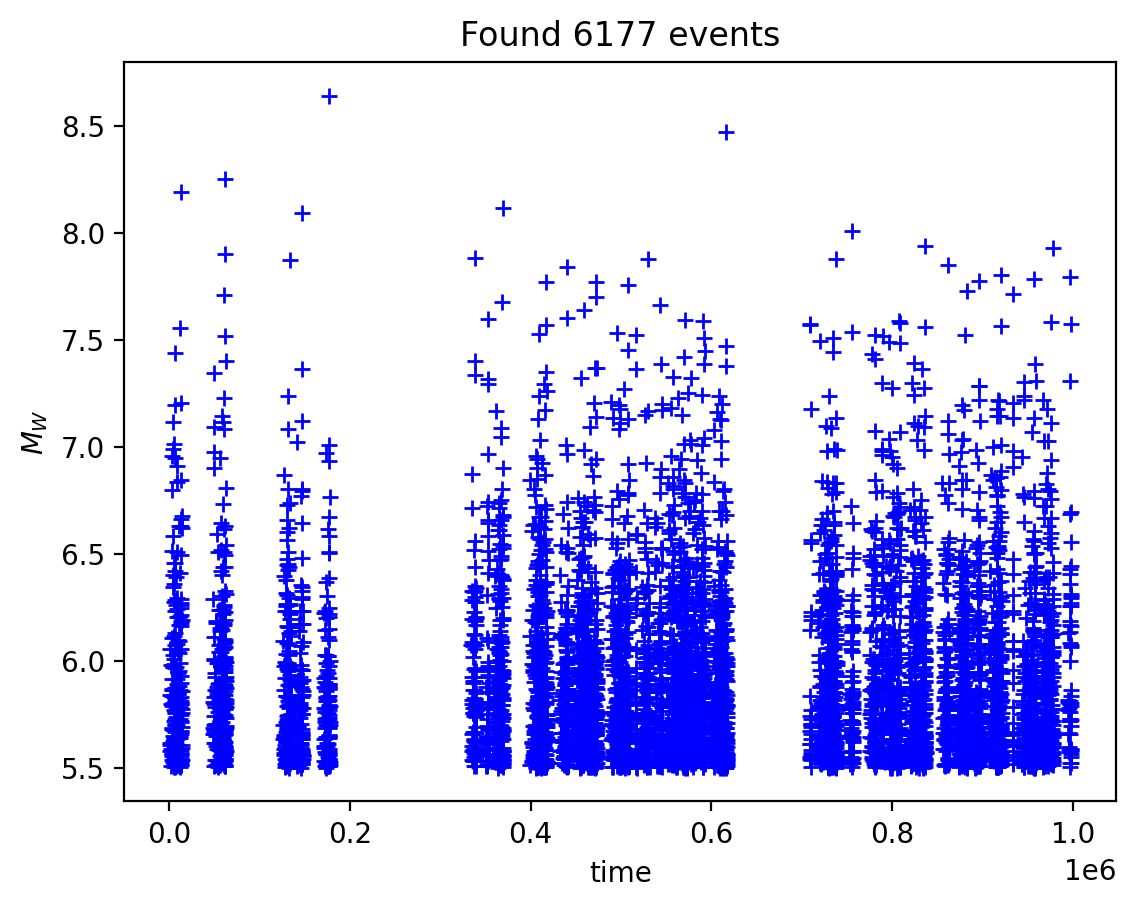

In [3]:
def get_most_recent_output_folder_name():
    most_recent_output_folder_name = sorted(glob.glob("./runs/*"))[-1]
    return most_recent_output_folder_name


most_recent_output_folder_name = get_most_recent_output_folder_name()
time_series = pickle.load(
    open(most_recent_output_folder_name + "/time_series.pickle", "rb")
)

index = np.where(time_series.event_magnitude > 0.0)[0]
plt.plot(time_series.time[index], time_series.event_magnitude[index], "b+")
plt.xlabel("time")
plt.ylabel("$M_W$")
plt.title(f"Found {index.size} events")
plt.show()


# Calculate and plot time to next event (ttne) for different magnitude ranges

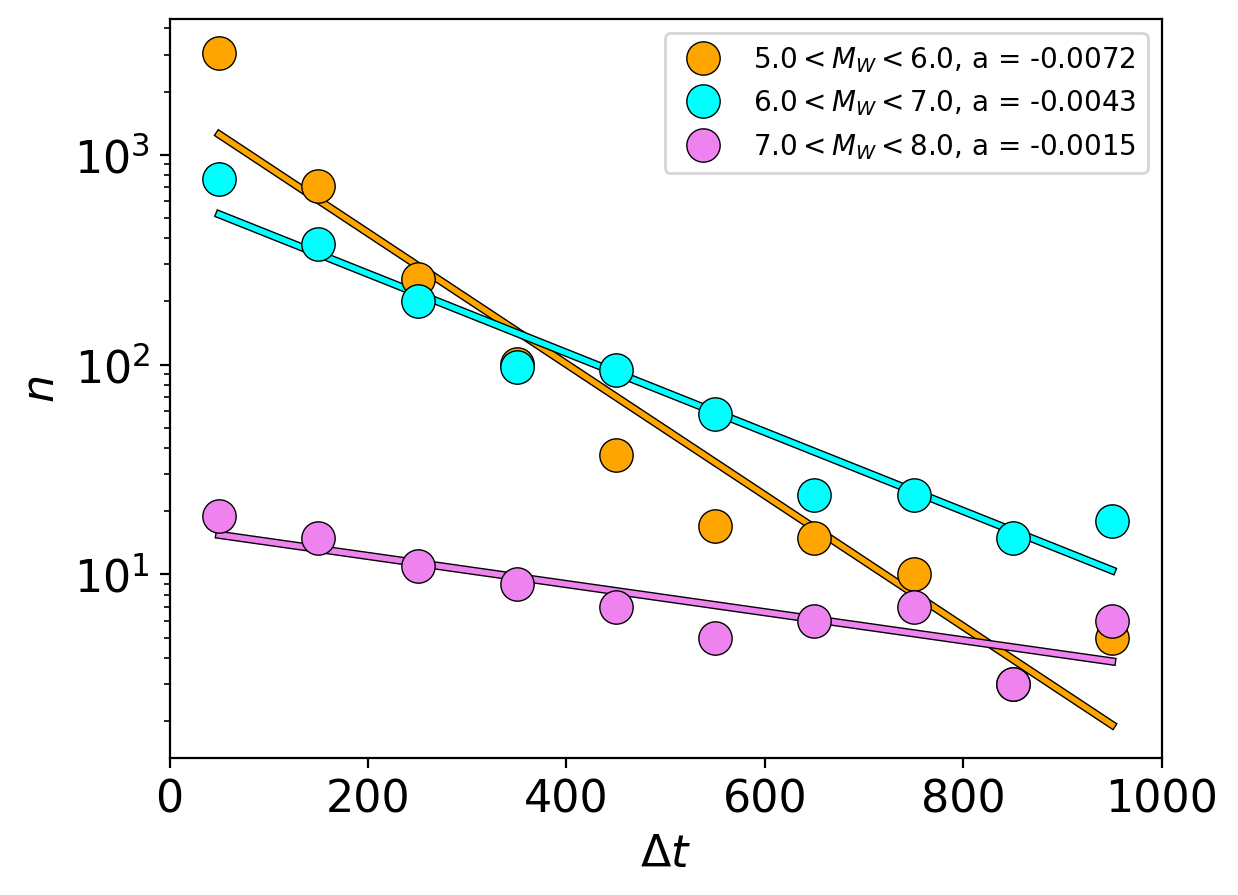

In [4]:
def fit_function(x, a, b):
    return a * x + b


delta_t_bins = np.linspace(0, 1000, 11)
delta_t_bin_centers = (np.diff(delta_t_bins) + delta_t_bins[0:-1]) - 0.5 * (
    delta_t_bins[1] - delta_t_bins[0]
)

counts_all, _ = np.histogram(
    np.diff(time_series.time[np.where(time_series.event_magnitude > 0.0)[0]]),
    bins=delta_t_bins,
)

magnitude_bins = np.array([5.0, 6.0, 7.0, 8.0])
counts = list()
models = list()
popts = list()
pcovs = list()
for i in range(len(magnitude_bins) - 1):
    lower_indices = np.where(time_series.event_magnitude >= magnitude_bins[i])
    upper_indices = np.where(time_series.event_magnitude < magnitude_bins[i + 1])
    a = np.intersect1d(lower_indices, upper_indices)
    counts_local, _ = np.histogram(np.diff(time_series.time[a]), bins=delta_t_bins)
    counts.append(counts_local)

    # Calculate best fit exponential
    popt, pcov = curve_fit(
        fit_function, delta_t_bin_centers, np.log(counts[i]), maxfev=5000
    )
    popts.append(popt)
    pcovs.append(pcov)
    model = fit_function(delta_t_bin_centers, popt[0], popt[1])
    model = np.exp(model)
    models.append(model)


markersize = 12
alpha = 1.0
fontsize = 16

plt.figure()

color_strings = ["orange", "cyan", "violet"]
for i in range(len(magnitude_bins) - 1):
    label_string = (
        f"{magnitude_bins[i]}"
        + "$ < M_W < $"
        + f"{magnitude_bins[i + 1]}, a = {popts[i][0]:0.4f}"
    )
    plt.semilogy(
        delta_t_bin_centers,
        models[i],
        "-",
        linewidth=3,
        color="k",
        alpha=alpha,
        zorder=10,
    )
    plt.semilogy(
        delta_t_bin_centers,
        models[i],
        "-",
        linewidth=2,
        color=color_strings[i],
        alpha=alpha,
        zorder=10,
    )

    plt.semilogy(
        delta_t_bin_centers,
        counts[i],
        "o",
        label=label_string,
        markeredgecolor="k",
        markeredgewidth=0.5,
        markersize=markersize,
        color=color_strings[i],
        alpha=alpha,
        zorder=20,
    )
plt.legend()
plt.xlim([0, np.max(delta_t_bins)])
plt.xlabel("$\Delta t$", fontsize=fontsize)
plt.ylabel("$n$", fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
plt.show()


# Visualize time to next event vs. differential event magnitude

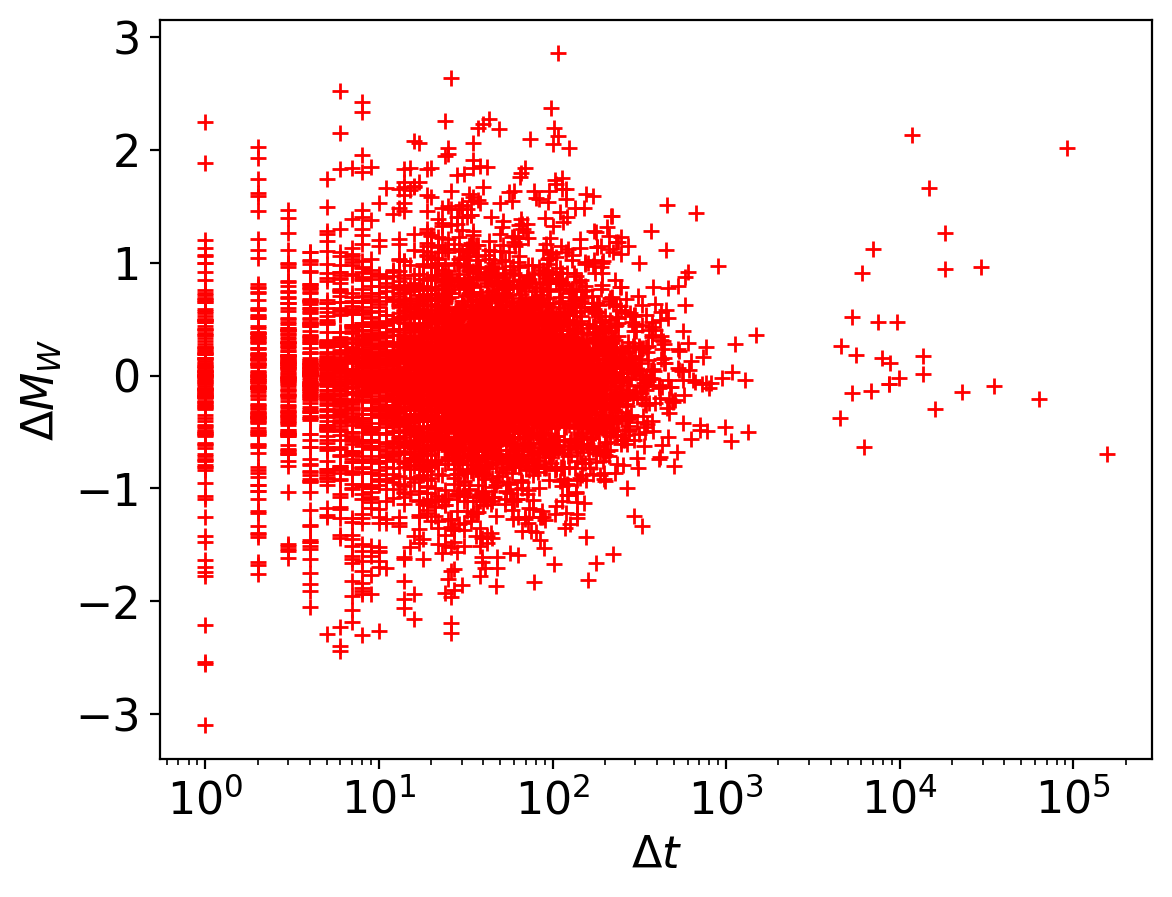

In [5]:
event_index = np.where(time_series.event_magnitude > 0.0)[0]

# TTNE vcounts_all, _ = np.histogram(
time_to_next_event = np.diff(time_series.time[event_index])
next_event_delta_magnitude = np.diff(time_series.event_magnitude[event_index])

# TODO: Color code (scatter) with event magnitude?
# event hypocenter distance

plt.figure()
plt.semilogx(time_to_next_event, next_event_delta_magnitude, "r+")
plt.xlabel("$\Delta t$", fontsize=fontsize)
plt.ylabel("$\Delta M_W$", fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
plt.show()


# Pretty plotting of time series

(5.0, 8.822637589445204)

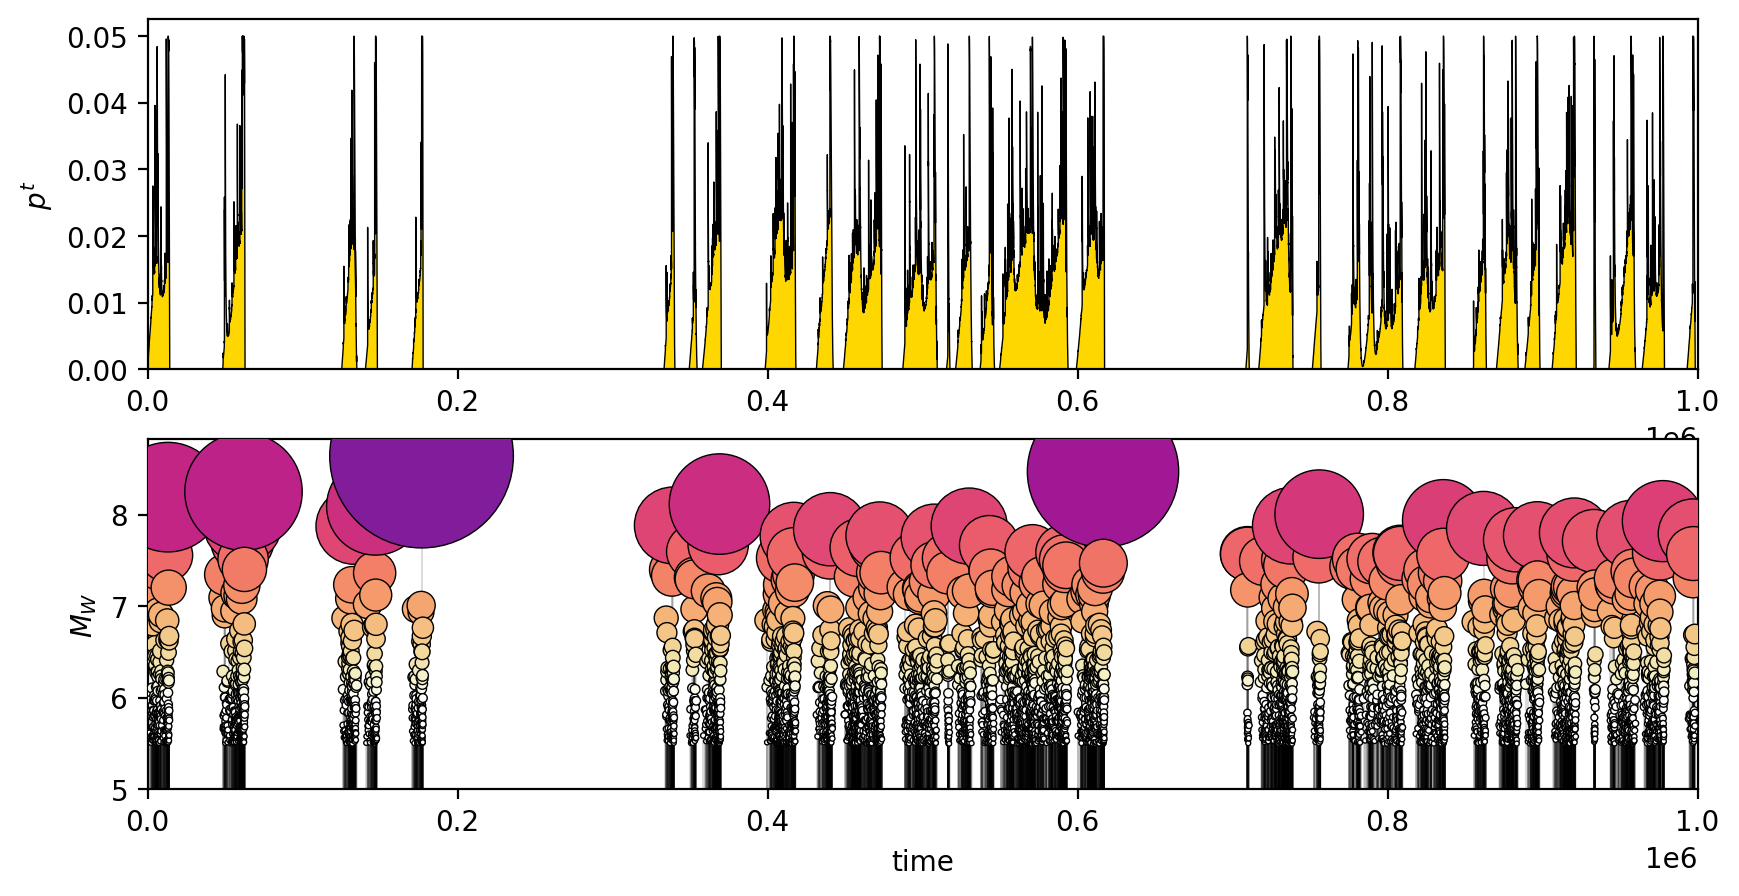

In [6]:
start_idx = 0
end_idx = len(time_series.time)
minimum_event_moment_magnitude = 5.0

event_idx = np.where(time_series.event_trigger_flag == 1)[0]
figsize = (10, 5)
plt.figure(figsize=figsize)

# Plot probability time series
plt.subplot(2, 1, 1)
plt.plot(
    time_series.time[start_idx:end_idx],
    time_series.probability_weight[start_idx:end_idx],
    "-k",
    linewidth=0.5,
)
plt.plot(
    [time_series.time[start_idx], time_series.time[end_idx - 1]],
    [0, 0],
    "-k",
    linewidth=0.5,
)
plt.fill_between(
    time_series.time[start_idx:end_idx],
    time_series.probability_weight[start_idx:end_idx],
    np.zeros_like(time_series.time[start_idx:end_idx]),
    time_series.probability_weight[start_idx:end_idx] > 0,
    color="gold",
    alpha=1.0,
    edgecolor=None,
)

plt.fill_between(
    time_series.time[start_idx:end_idx],
    time_series.probability_weight[start_idx:end_idx],
    np.zeros_like(time_series.time[start_idx:end_idx]),
    time_series.probability_weight[start_idx:end_idx] < 0,
    color="dodgerblue",
    alpha=1.0,
    edgecolor=None,
)
plt.xlim([start_idx, end_idx])
plt.gca().set_ylim(bottom=0.0)
plt.ylabel("$p^t$")

# Plot earthquake magnitude stem plot
plt.subplot(2, 1, 2)
for i in range(event_idx.size):
    plt.plot(
        [
            time_series.time[event_idx[i]],
            time_series.time[event_idx[i]],
        ],
        [
            minimum_event_moment_magnitude,
            time_series.event_magnitude[event_idx[i]],
        ],
        "-",
        linewidth=0.1,
        zorder=10,
        color="k",
    )

cmap = cc.cm.CET_L17
magnitude_plot_size = 1e-5 * 10 ** time_series.event_magnitude[event_idx]
plt.scatter(
    time_series.time[event_idx],
    time_series.event_magnitude[event_idx],
    s=magnitude_plot_size,
    c=time_series.event_magnitude[event_idx],
    zorder=20,
    alpha=1.0,
    edgecolors="k",
    linewidths=0.5,
    cmap=cmap,
    vmin=6.0,
    vmax=9.0,
)

plt.xlabel("time")
plt.ylabel("$M_W$")
plt.xlim([start_idx, end_idx])
plt.gca().set_ylim(bottom=minimum_event_moment_magnitude)

# Visualize aftershock sequence

(5.0, 8.822637589445204)

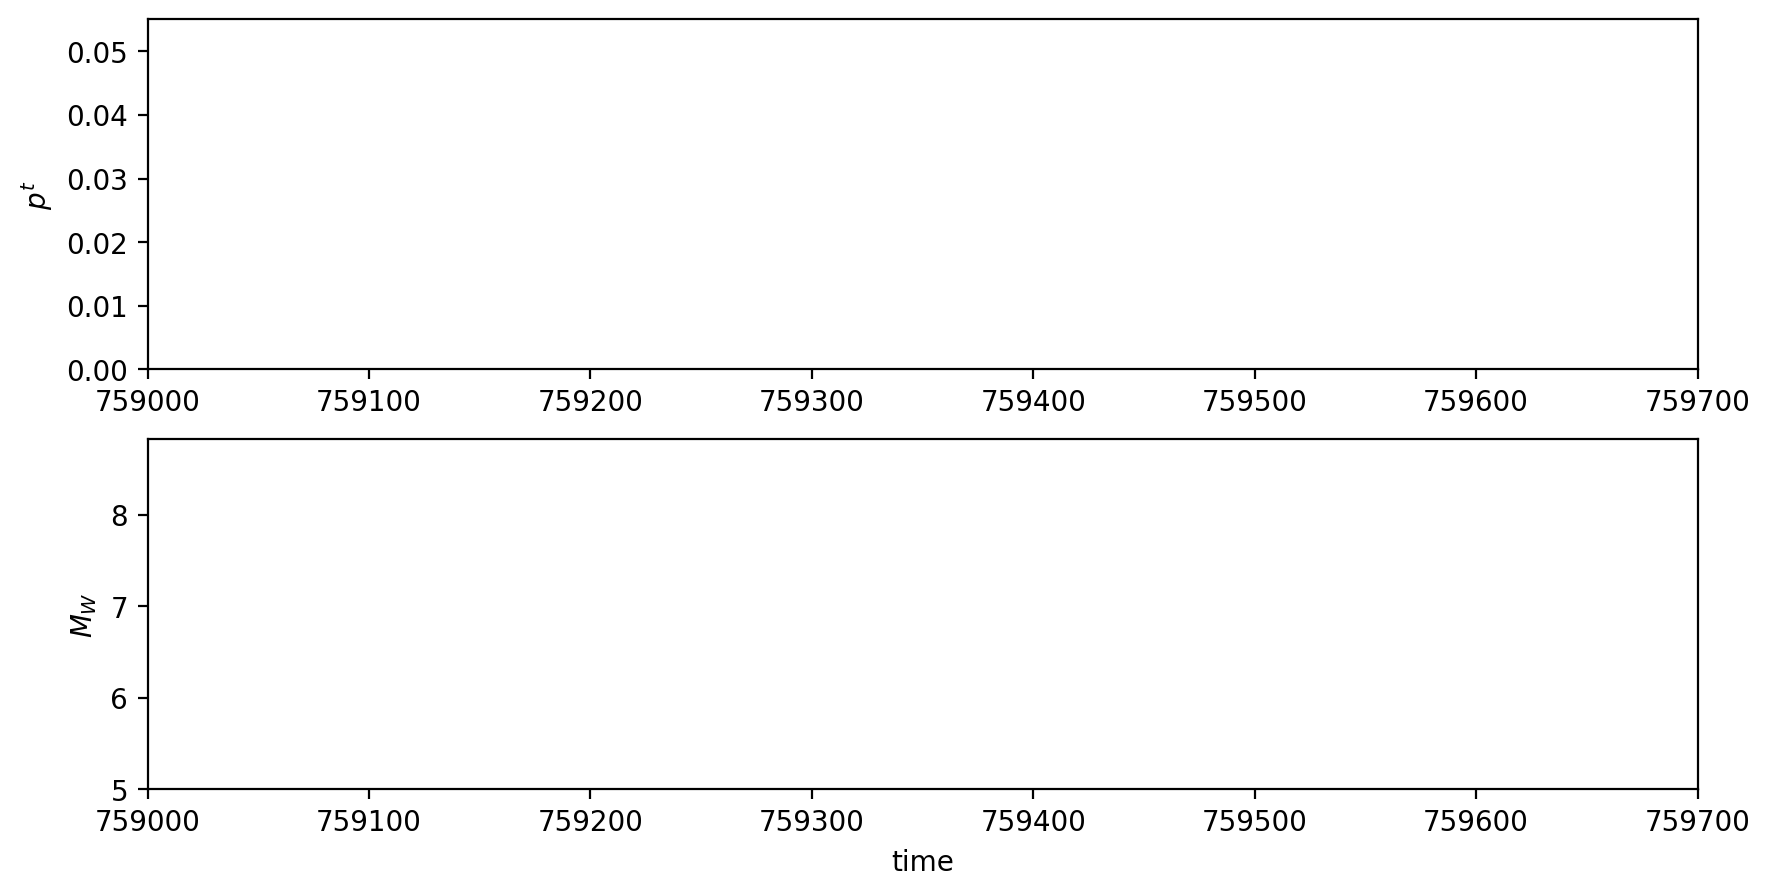

In [7]:
start_idx = 759000
end_idx = 759700
minimum_event_moment_magnitude = 5.0

event_idx = np.where(time_series.event_trigger_flag == 1)[0]
figsize = (10, 5)
plt.figure(figsize=figsize)

# Plot probability time series
plt.subplot(2, 1, 1)
plt.plot(
    time_series.time[start_idx:end_idx],
    time_series.probability_weight[start_idx:end_idx],
    "-k",
    linewidth=0.5,
)
plt.plot(
    [time_series.time[start_idx], time_series.time[end_idx - 1]],
    [0, 0],
    "-k",
    linewidth=0.5,
)
plt.fill_between(
    time_series.time[start_idx:end_idx],
    time_series.probability_weight[start_idx:end_idx],
    np.zeros_like(time_series.time[start_idx:end_idx]),
    time_series.probability_weight[start_idx:end_idx] > 0,
    color="gold",
    alpha=1.0,
    edgecolor=None,
)

plt.fill_between(
    time_series.time[start_idx:end_idx],
    time_series.probability_weight[start_idx:end_idx],
    np.zeros_like(time_series.time[start_idx:end_idx]),
    time_series.probability_weight[start_idx:end_idx] < 0,
    color="dodgerblue",
    alpha=1.0,
    edgecolor=None,
)
plt.xlim([start_idx, end_idx])
plt.gca().set_ylim(bottom=0.0)
plt.ylabel("$p^t$")

# Plot earthquake magnitude stem plot
plt.subplot(2, 1, 2)
for i in range(event_idx.size):
    plt.plot(
        [
            time_series.time[event_idx[i]],
            time_series.time[event_idx[i]],
        ],
        [
            minimum_event_moment_magnitude,
            time_series.event_magnitude[event_idx[i]],
        ],
        "-",
        linewidth=0.1,
        zorder=10,
        color="k",
    )

cmap = cc.cm.CET_L17
magnitude_plot_size = 1e-5 * 10 ** time_series.event_magnitude[event_idx]
plt.scatter(
    time_series.time[event_idx],
    time_series.event_magnitude[event_idx],
    s=magnitude_plot_size,
    c=time_series.event_magnitude[event_idx],
    zorder=20,
    alpha=1.0,
    edgecolors="k",
    linewidths=0.5,
    cmap=cmap,
    vmin=6.0,
    vmax=9.0,
)

plt.xlabel("time")
plt.ylabel("$M_W$")
plt.xlim([start_idx, end_idx])
plt.gca().set_ylim(bottom=minimum_event_moment_magnitude)

# Visualize potential foreshocks?


# Analysis of event centroid locations

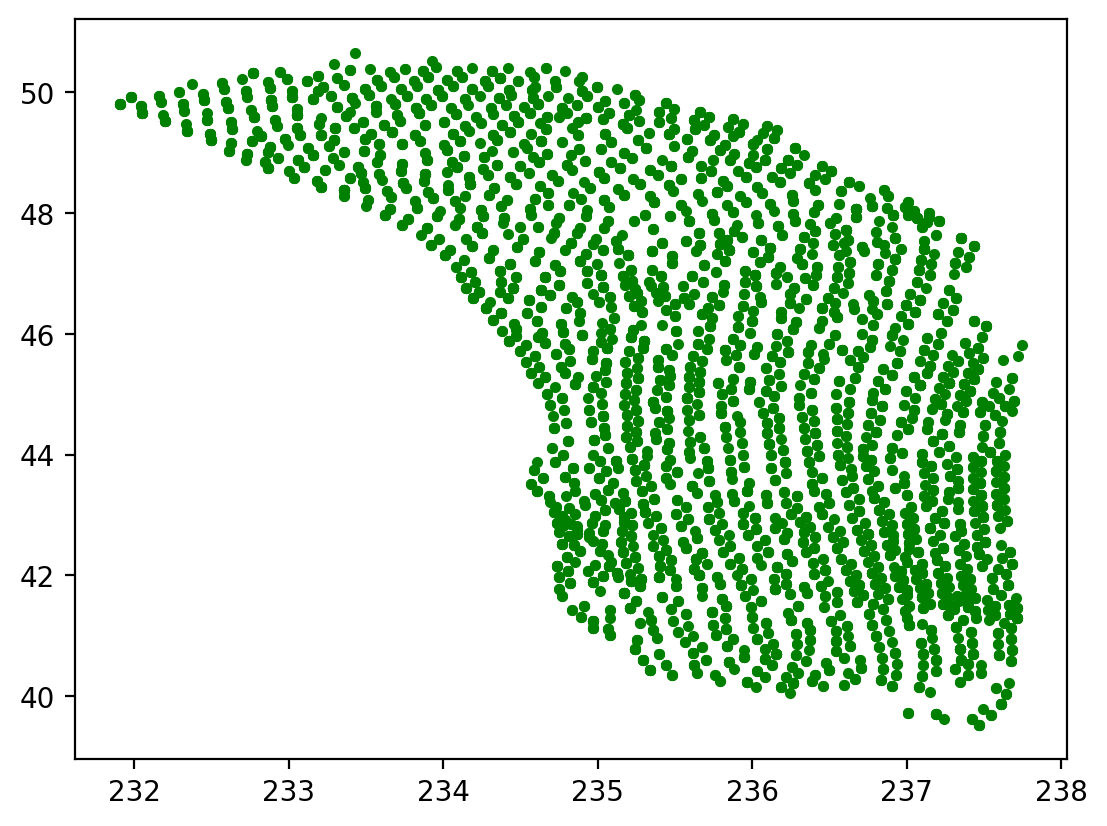

In [11]:

plt.figure()
plt.plot(time_series.event_longitude[index], time_series.event_latitude[index], "g.")
plt.show()

# Plot scalar moment history